In [1]:
# import statements
import sys
sys.path.append('../../../alg')
import marching_army as ma, distance_buffer as db

from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from scipy.stats import truncnorm
from functools import partial
import matplotlib.pyplot as plt, numpy as np
import pandas as pd, geopandas as gpd
import shapely
import math
import pyproj
import fiona


%matplotlib inline

# METHODS

In [70]:
def generate_grid(rad, bds):
    # get the largest diagonal dist and this is what we will make 
    #our regtangle of points on the grid based on (so when we shift/rotate the whole 
    #shape will be covered still)
    [west, south, east, north] = bds
    bounds = [west,south,east,north]
    diags = [db.eucdist(west,north,east,south)[0], db.eucdist(west,south,east,north)[0]]
    maxdiag = max(diags)
    
    #generate the "two" grids
    r = rad
    x_shift = (r/2.0)*math.sqrt(3)
    y_shift = (3.0/2.0)*r

    x_ints = int(math.ceil(maxdiag/x_shift))
    y_ints = int(math.ceil(maxdiag/y_shift))

    stopx = bounds[0]+(x_ints*x_shift)
    stopy = bounds[1]+(y_ints*y_shift)

    # create the equally spaced coord points for the "grid" cand pts
    xs_all = np.linspace(west,stopx,x_ints+1)
    ys_all = np.linspace(south,stopy,y_ints+1)
    print(xs_all)
    print(ys_all)
    
    # now take odds with odds and evens with evens ("2" grids)
    xs_odd = []
    xs_even = []
    ys_odd = []
    ys_even = []

    for i in range(0,len(xs_all)):
        if i%2 == 0:
            xs_even.append(xs_all[i])
        else:
            xs_odd.append(xs_all[i])
    for i in range(0,len(ys_all)):
        if i%2 == 0:
            ys_even.append(ys_all[i])
        else:
            ys_odd.append(ys_all[i])

    xs_odd = np.array(xs_odd)
    xs_even = np.array(xs_even)
    ys_odd = np.array(ys_odd)
    ys_even = np.array(ys_even)

    x_grid1, y_grid1 = np.meshgrid(xs_odd, ys_odd)
    x_grid2, y_grid2 = np.meshgrid(xs_even, ys_even)
    
    # create the data dicts that will create the geodataframe
    data1={'x':x_grid1.flatten(), 'y':y_grid1.flatten()}
    data2={'x':x_grid2.flatten(), 'y':y_grid2.flatten()}
    
    data_all = data1.copy()   # start with x's keys and values
    data_all.update(data2)

    grid1gdf = gpd.GeoDataFrame(data={'x':x_grid1.flatten(), 'y':y_grid1.flatten()})
    grid2gdf = gpd.GeoDataFrame(data={'x':x_grid2.flatten(), 'y':y_grid2.flatten()})
    
    gridgdf = gpd.GeoDataFrame( pd.concat( [grid1gdf,grid2gdf], ignore_index=True) )
    gridgdf['geometry'] = gridgdf.apply(lambda row: Point((row['x'], row['y'])), axis=1)

    return gridgdf

# Experiments

In [71]:
# check out some fds properties

smol = generate_grid(10.0, [0,0,100,100])

[west,south,east,north] = [0,0,100,100]

[  0.           8.66025404  17.32050808  25.98076211  34.64101615
  43.30127019  51.96152423  60.62177826  69.2820323   77.94228634
  86.60254038  95.26279442 103.92304845 112.58330249 121.24355653
 129.90381057 138.56406461 147.22431864]
[  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150.]


In [72]:
smol

,x,y,geometry
0,8.660254,15.0,POINT (8.660254037844386 15)
1,25.980762,15.0,POINT (25.98076211353316 15)
2,43.301270,15.0,POINT (43.30127018922192 15)
3,60.621778,15.0,POINT (60.6217782649107 15)
4,77.942286,15.0,POINT (77.94228634059947 15)
5,95.262794,15.0,POINT (95.26279441628824 15)
6,112.583302,15.0,POINT (112.583302491977 15)
7,129.903811,15.0,POINT (129.9038105676658 15)
8,147.224319,15.0,POINT (147.2243186433546 15)
9,8.660254,45.0,POINT (8.660254037844386 45)


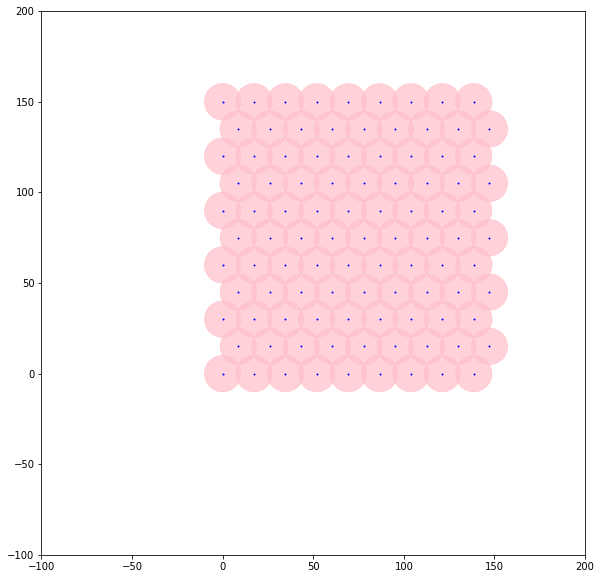

In [75]:
# plot the cut-up city
fig1, ax1 = plt.subplots(figsize=(10,10))

smol_list = zip(smol['x'],smol['y'])
db.plot_radii(ax1, smol_list, 10.0, alpha=0.7, color="pink")
ax1.scatter(x=smol['x'], y=smol['y'], s=1, c='b', linewidth=1, zorder=3)


ax1.set_xlim(west-100, east+100)
ax1.set_ylim(south-100, north+100)
plt.gca().set_aspect('equal', adjustable='box')
ax1.axis('on')
plt.show()

In [17]:
smol_list = zip(smol['x'],smol['y'])

In [33]:
db.eucdist(smol_list[0][0], smol_list[0][1], smol_list[50][0], smol_list[50][1])

[19.03800794536492, 9.20151991520966, 16.666666666666668]

In [35]:
#[dist,xdist,ydist]
db.eucdist(smol_list[0][0], smol_list[0][1], smol_list[1][0], smol_list[1][1])

[18.403039830419324, 18.403039830419324, 0.0]

In [34]:
math.sqrt(3)*10

17.32050807568877

In [38]:
(10.0/2.0)*math.sqrt(3) * 2

17.32050807568877

In [23]:
smol_list[1]

(27.604559745628983, 16.666666666666668)

In [39]:
19.03800794536492/math.sqrt(3)

10.991599012090672

In [40]:
(3/2.0)*10.991599012090672

16.487398518136008

In [51]:
x = math.sqrt(3)*(10.0/2.0)
y=(3/2.0)*10
pts = []
ptsx = []
ptsy = []
sty = 0
stx = 0
curx = stx
cury = sty
endy = 151.0
endx = 151.0
for i in range(0, 10):
    cury = i*y
    if i%2==0:
        curx = 0.0
    else:
        curx = x
    for j in range(0,10):
        pts.append((curx,cury))
        ptsx.append(curx)
        ptsy.append(cury)
        curx+=(x*2.0)


        
    

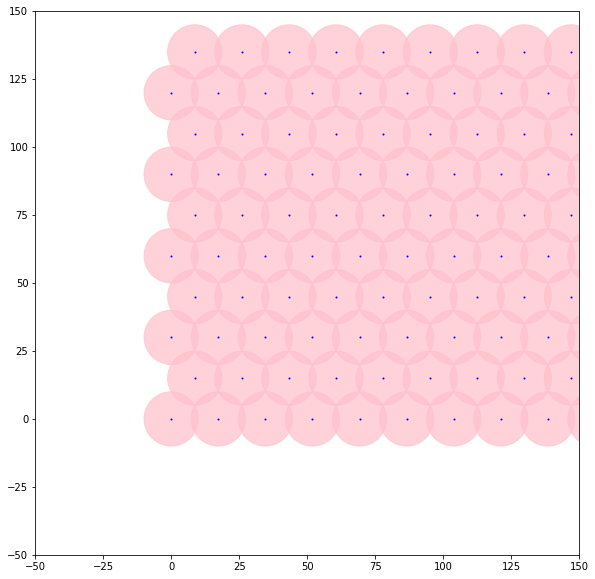

In [53]:
# plot the cut-up city
fig2, ax2 = plt.subplots(figsize=(10,10))

db.plot_radii(ax2, pts, 10.0, alpha=0.7, color="pink")
ax2.scatter(x=ptsx, y=ptsy, s=1, c='b', linewidth=1, zorder=3)


ax2.set_xlim(west-50, east+50)
ax2.set_ylim(south-50, north+50)
plt.gca().set_aspect('equal', adjustable='box')
ax2.axis('on')
plt.show()

In [54]:
xs_all

NameError: name 'xs_all' is not defined

In [ ]:
[  0.           9.20151992  18.40303983  27.60455975  36.80607966
  46.00759958  55.20911949  64.41063941  73.61215932  82.81367924
  92.01519915 101.21671907 110.41823898 119.6197589  128.82127881
 138.02279873 147.22431864]
[  0.          16.66666667  33.33333333  50.          66.66666667
  83.33333333 100.         116.66666667 133.33333333 150.        ]

In [65]:
ptsx[0:20]

[0.0,
 17.32050807568877,
 34.64101615137754,
 51.96152422706631,
 69.28203230275508,
 86.60254037844385,
 103.92304845413261,
 121.24355652982138,
 138.56406460551014,
 155.8845726811989,
 8.660254037844386,
 25.980762113533157,
 43.301270189221924,
 60.621778264910695,
 77.94228634059947,
 95.26279441628824,
 112.58330249197701,
 129.90381056766577,
 147.22431864335454,
 164.5448267190433]

In [67]:
ptsy

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 45.0,
 45.0,
 45.0,
 45.0,
 45.0,
 45.0,
 45.0,
 45.0,
 45.0,
 45.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 60.0,
 75.0,
 75.0,
 75.0,
 75.0,
 75.0,
 75.0,
 75.0,
 75.0,
 75.0,
 75.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 105.0,
 105.0,
 105.0,
 105.0,
 105.0,
 105.0,
 105.0,
 105.0,
 105.0,
 105.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 135.0,
 135.0,
 135.0,
 135.0,
 135.0,
 135.0,
 135.0,
 135.0,
 135.0,
 135.0]

In [69]:
#[west, south, east, north] = bds
bounds = [west,south,east,north]
diags = [db.eucdist(west,north,east,south)[0], db.eucdist(west,south,east,north)[0]]
maxdiag = max(diags)

#generate the "two" grids
r = 10.0
x_shift = (r/2.0)*math.sqrt(3)
y_shift = (3.0/2.0)*r
print(x_shift)
print(y_shift)

x_ints = int(math.ceil(maxdiag/x_shift))
y_ints = int(math.ceil(maxdiag/y_shift))
print(x_ints)
print(y_ints)
stopx = bounds[0]+(x_ints*x_shift)
stopy = bounds[1]+(y_ints*y_shift)
print(stopx)
print(stopy)

# create the equally spaced coord points for the "grid" cand pts
xs_all = np.linspace(west,stopx,x_ints+1)
ys_all = np.linspace(south,stopy,y_ints+1)
print(xs_all)
print(ys_all)

8.66025403784
15.0
17
10
147.224318643
150.0
[  0.           8.66025404  17.32050808  25.98076211  34.64101615
  43.30127019  51.96152423  60.62177826  69.2820323   77.94228634
  86.60254038  95.26279442 103.92304845 112.58330249 121.24355653
 129.90381057 138.56406461 147.22431864]
[  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150.]
